# Road Signs Deep Learning classification 

---

![banner](banner.jpg)

---

## Content Table
- [1. Environment Preparation](#0.-Environment-Preparation)
- [2. Data Preprocessing](#2.-Data-Preprocessing)
  - [A. Data Loading](#A.-Data-Loading)
  - [B. Data Augmentation](#B.-Data-Augmentation)
- [3. Model Development](#3.-Model-Development)
- [4. Model Evaluation](#4.-Model-Evaluation)
- [5. Results Interpretation](#5.-Results-Interpretation)
  - [A. Misclassification](#A.-Misclassification)

### Project Overview
This project aims to classify road signs using a Convolutional Neural Network (CNN), important for autonomous driving systems. The GTSRB dataset is used, with data augmentation and model optimization techniques applied to improve performance.

### Objectives
- Classify road signs using CNNs.
- Preprocess and augment the GTSRB dataset.
- Design, train, and evaluate the CNN model.
- Optimize performance with techniques like regularization and transfer learning.
- Interpret the model predictions and evaluation results

### Dataset
The **GTSRB dataset** contains 50,000+ images of road signs. It will be split into training, validation, and test sets with data augmentation to increase robustness & generalization.

### Dependencies
- **Python**, **TensorFlow/Keras**, **Scikit-learn**, **OpenCV**, **Numpy**, **Pandas**, **Matplotlib**, **Seaborn**

---

## 1. Environment Preparation

In [1]:
import tensorflow as tf

# List all Gpus
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected.")

GPUs detected: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1727952113.053454    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727952113.215532    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727952113.215785    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
import tensorflow.keras as keras

random_seed = 42 # Set random seed for reproducibility

In [3]:
train_data_path = "Data/archive/" # Path to the training data
image_size = (64, 64) # Target image size for the model
model_export_path = "Model/traffic_sign_classifier.keras" # Path to save the model
model_path = "Model/traffic_sign_classifier.keras" # Path to load the model

---

## 2. Data Preprocessing

### A. Data Loading

In [4]:
def load_data(meta_data, data_path, image_size, is_test=False):
    """
    Loads and preprocesses image data for training or testing.

    Parameters:
    meta_data (pd.DataFrame): A DataFrame containing metadata about the images, including file paths and class IDs.
    data_path (str): The base directory path where the image files are located.
    image_size (tuple): The target size for resizing the images (width, height).
    is_test (bool): A flag indicating whether the data is for testing. If True, the labels are not one-hot encoded.

    Returns:
    tuple: A tuple containing:
        - X (np.ndarray): An array of preprocessed images.
        - Y (np.ndarray): An array of labels, either one-hot encoded or as class IDs depending on the is_test flag.
    """
    # Encode labels as one-hot vectors if not in test mode, otherwise use class IDs directly
    Y = (
        keras.utils.to_categorical(meta_data["ClassId"])
        if not is_test
        else meta_data["ClassId"]
    )
    
    # Load and preprocess images
    X = np.array(
        [
            np.array(
                # Read image, convert from BGR to RGB, resize to target size
                cv2.resize(cv2.imread(data_path + path)[..., ::-1], image_size),
                dtype=np.float64,
            )
            for path in tqdm(meta_data.Path)  # Iterate over all image paths with a progress bar
        ]
    )
    
    # Return preprocessed images and labels
    return X, Y

In [5]:
train_meta_data = pd.read_csv("Data/archive/Train.csv")
train_meta_data = train_meta_data[["ClassId", "Path"]]
print("Loading training data...")
X, Y = load_data(train_meta_data, train_data_path, image_size)
print(f"Loaded {len(X)} training samples.")

Loading training data...


100%|██████████| 39209/39209 [00:16<00:00, 2325.71it/s]


Loaded 39209 training samples.


In [6]:
X.shape, Y.shape

((39209, 64, 64, 3), (39209, 43))

In [7]:
train_meta_data.ClassId.unique()

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

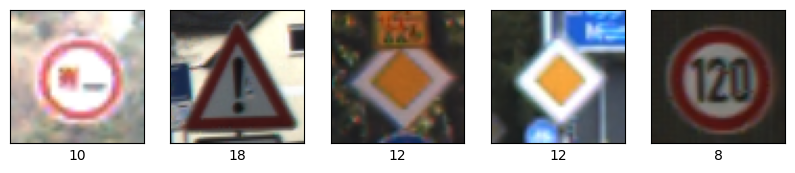

In [8]:
def plot_random_samples(meta_data, X):
    """
    Plots random samples of images with their corresponding class IDs.

    Parameters:
    meta_data (pd.DataFrame): A DataFrame containing metadata about the images, including class IDs.
    X (np.ndarray): An array of preprocessed images.

    Returns:
    None
    """
    # Create a figure with 1 row and 5 columns of subplots
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    
    for i in range(5):
        # Select a random index
        n = randint(0, len(X))
        
        # Display the image in the subplot
        axes[i].imshow(X[n] / 255)
        
        # Set the label of the subplot to the class ID of the image
        axes[i].set_xlabel(meta_data.ClassId.iloc[n])
        
        # Remove x and y ticks
        axes[i].set_xticks(())
        axes[i].set_yticks(())
    
    plt.show()

# Call the function to plot random samples from the training data
plot_random_samples(train_meta_data, X)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=random_seed,
    # stratify=Y,
)

In [10]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((31367, 64, 64, 3), (7842, 64, 64, 3), (31367, 43), (7842, 43))

### B. Data Augmentation

In [11]:
# Create an ImageDataGenerator for data augmentation during training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,  # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by 10% of the height
    zoom_range=0.1,  
    rotation_range=10,  
    brightness_range=[0.9, 1.1],  
)

# Create an iterator for the training data with a batch size of 64
it_train = train_datagen.flow(X_train, Y_train, batch_size=64)

it_val = train_datagen.flow(X_val, Y_val, batch_size=64)

---

## 3. Model Development

In [12]:
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Rescaling,
    Input,
)

# Create the model structure
model = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Rescaling(1.0 / 255.0),
        Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(units=256, activation="relu"),
        Dropout(0.5),
        Dense(units=43, activation="softmax"),
    ]
)


print(model.summary())

I0000 00:00:1727952139.243472    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727952139.243830    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727952139.244066    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727952139.327644    8694 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,779 (940.54 KB)

 Trainable params: 240,299 (938.67 KB)

 Non-trainable params: 480 (1.88 KB)

None


In [13]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
earlystop = keras.callbacks.EarlyStopping(patience=4) # Stop training early if the validation loss stops improving

history = model.fit(it_train, validation_data=it_val, epochs=30, callbacks=[earlystop])

Epoch 1/30


/mnt/Files/Sorbonne_Data_Analytics_SDA/Cours/Deep_Learning_Dafnis-Krasniqi/Road_Signs_Deep_Learning_Classification/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727952142.603860   46320 service.cc:146] XLA service 0x7642cc014e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727952142.603884   46320 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-10-03 11:42:22.682187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 11:42:23.00

  5/491 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.0264 - loss: 4.5764

I0000 00:00:1727952147.553751   46320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


239/491 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.3125 - loss: 2.7310

2024-10-03 11:42:40.645204: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2234', 116 bytes spill stores, 116 bytes spill loads



491/491 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.4453 - loss: 2.1168 - val_accuracy: 0.8016 - val_loss: 0.6659
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9005 - loss: 0.3207 - val_accuracy: 0.9443 - val_loss: 0.1816
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9525 - loss: 0.1510 - val_accuracy: 0.9828 - val_loss: 0.0628
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9704 - loss: 0.0951 - val_accuracy: 0.9699 - val_loss: 0.0947
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.9763 - loss: 0.0771 - val_accuracy: 0.9865 - val_loss: 0.0445
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.9791 - loss: 0.0636 - val_accuracy: 0.9855 - val_loss: 0.0459
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.9851 - loss: 0.0476 - val_accuracy: 0.9893 - val_loss: 0.0359
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9858 - loss: 0.0465 - val_accurac

Max val_acc 0.9970670938491821


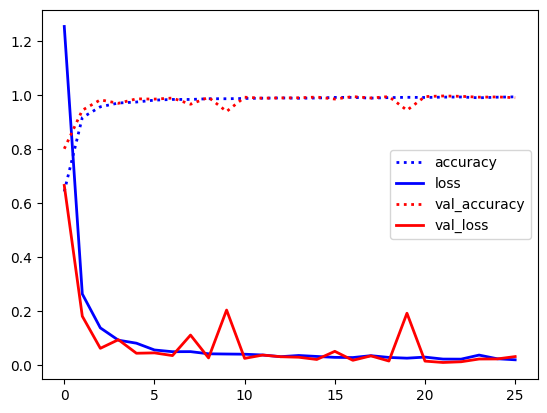

In [15]:
import pandas as pd
import numpy as np

pd.DataFrame(history.history).plot(lw=2, style=["b:", "b-", "r:", "r-"]) # PLot the training and validation metrics
print("Max val_acc", np.max(history.history["val_accuracy"]))

In [16]:
model.save(model_export_path) # Save the model

---

## 4. Model Evaluation

Uncomment the line below to load the saved model

In [17]:
#model = keras.models.load_model(model_path) # Load the model

In [18]:
test_data_path = "Data/archive/"
test_meta_data = pd.read_csv("Data/archive/Test.csv")
test_meta_data = test_meta_data[["ClassId", "Path"]]
print("Loading test data...")
X_test, Y_test = load_data(test_meta_data, test_data_path, image_size, is_test=True) # Load the test data
print(f"Loaded {len(X_test)} test samples.")

Loading test data...


100%|██████████| 12630/12630 [00:06<00:00, 2100.58it/s]


Loaded 12630 test samples.


In [19]:
X_test.shape, Y_test.shape

((12630, 64, 64, 3), (12630,))

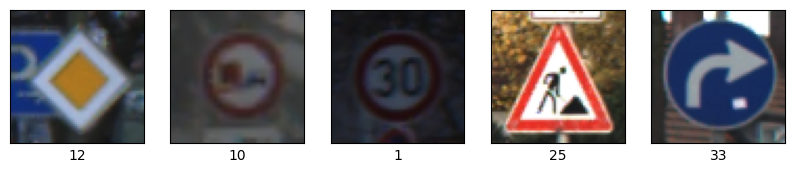

In [20]:
plot_random_samples(test_meta_data, X_test)

In [21]:
pred = model.predict(X_test, verbose=1) # Make predictions on the test data

2024-10-03 11:56:15.773672: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 620789760 exceeds 10% of free system memory.
2024-10-03 11:56:16.572892: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 620789760 exceeds 10% of free system memory.


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [22]:
pred.shape

(12630, 43)

In [23]:
Y_pred = np.argmax(pred, axis=1)
Y_pred[:5]

array([16,  1, 38, 33, 11])

In [24]:
Y_test

0        16
1         1
2        38
3        33
4        11
         ..
12625    12
12626    33
12627     6
12628     7
12629    10
Name: ClassId, Length: 12630, dtype: int64

In [25]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
)

print(classification_report(Y_test, Y_pred))
print("Accuracy: ", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.98      0.99      0.99       720
           2       1.00      0.98      0.99       750
           3       1.00      0.97      0.99       450
           4       0.99      0.98      0.99       660
           5       0.95      1.00      0.97       630
           6       1.00      0.91      0.95       150
           7       1.00      0.96      0.98       450
           8       0.98      0.98      0.98       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.88      1.00      0.94       420
          12       1.00      0.90      0.95       690
          13       1.00      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred) # Compute the confusion matrix

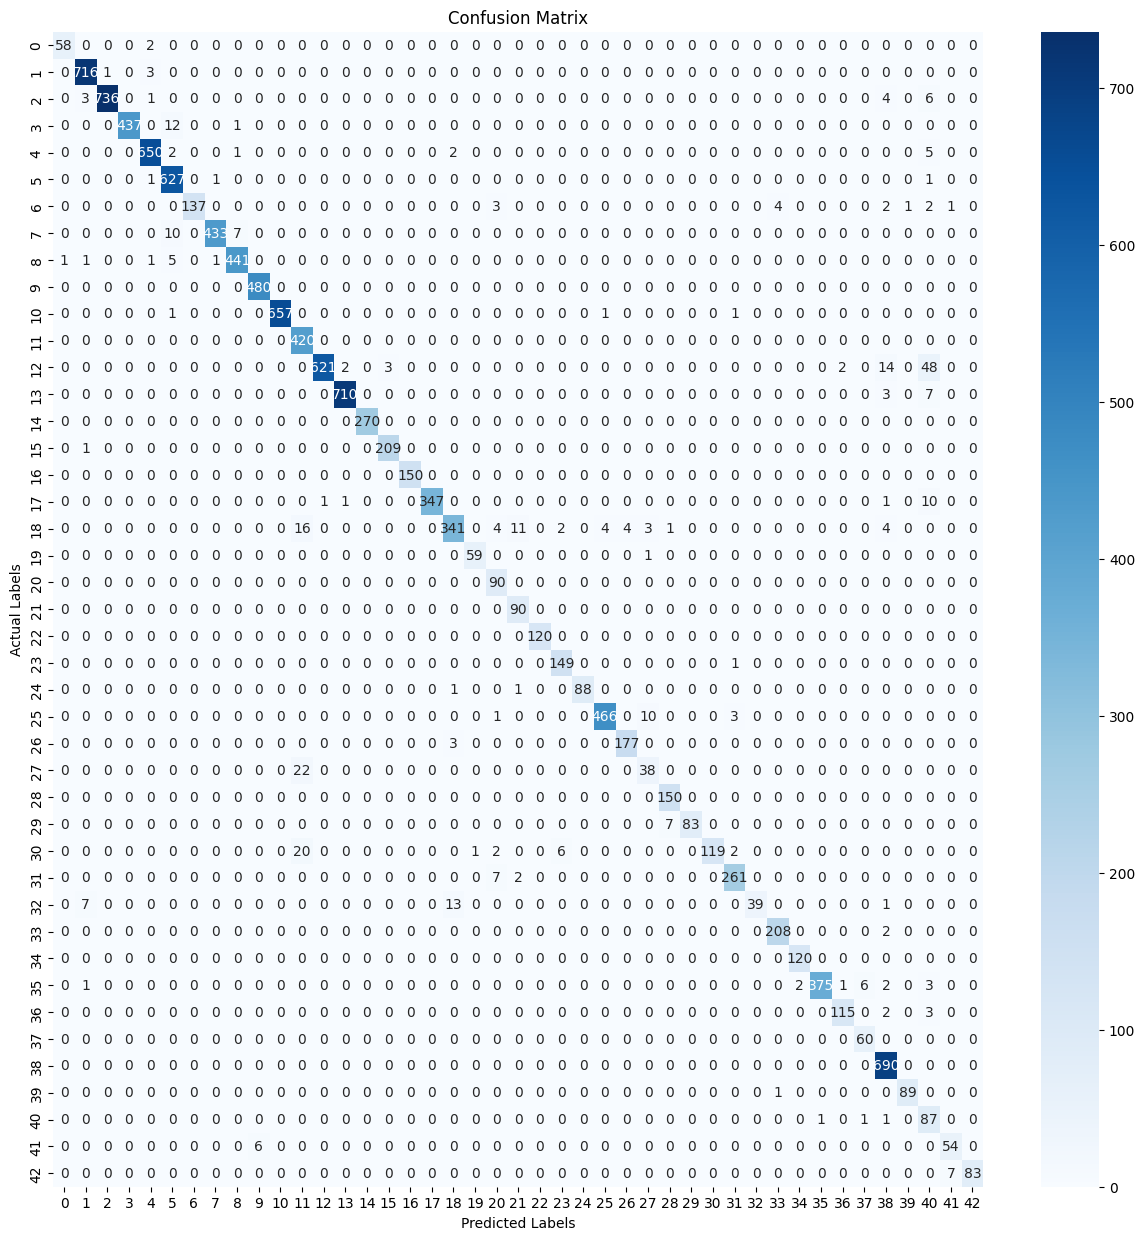

In [27]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

---

## 5. Interpretation

### A. Misclassification

In [28]:
Y_test.shape,Y_pred.shape # Verify the shapes of the true and predicted labels

((12630,), (12630,))

In [29]:
misclassified_samples = np.nonzero(Y_test != Y_pred)[0] # Find the indices of misclassified samples
misclassified_samples.shape

(380,)

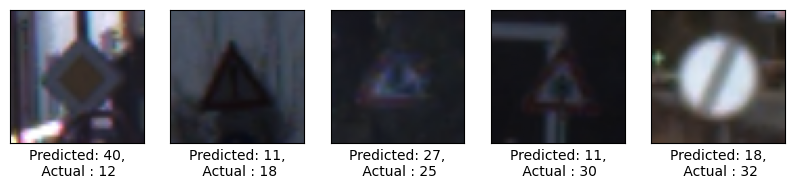

In [30]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
nb_misclassifications = 5
fig, axes = plt.subplots(1, nb_misclassifications,  figsize=(10, nb_misclassifications))
for nr, i in enumerate(misclassified_samples[:nb_misclassifications]):
    axes[nr].imshow(X_test[i]/255.0)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (Y_pred[i],Y_test[i]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show()

### B. Prediction Visualization - GradCam